In [1]:
from __future__ import print_function

import os
import math
import requests
import time

from IPython import display
from matplotlib import cm
from matplotlib import gridspec
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
from sklearn import metrics
import tensorflow as tf
from tensorflow.python.data import Dataset

tf.logging.set_verbosity(tf.logging.ERROR)
pd.options.display.max_rows = 10
pd.options.display.float_format = '{:.1f}'.format

In [2]:
def construct_feature_columns(input_features):
    """Construct the TensorFlow Feature Columns.
    Args:
        input_features: The names of the numerical input features to use.
    Returns:
        A set of feature columns
    """ 
    return set([tf.feature_column.numeric_column(my_feature)
                  for my_feature in input_features.columns])

In [3]:
def my_input_fn(features, targets, batch_size=1, shuffle=True, num_epochs=None):
    """Trains a neural network model.

    Args:
        features: pandas DataFrame of features
        targets: pandas DataFrame of targets
        batch_size: Size of batches to be passed to the model
          shuffle: True or False. Whether to shuffle the data.
        num_epochs: Number of epochs for which data should be repeated. None = repeat indefinitely
    Returns:
        Tuple of (features, labels) for next data batch
    """

    # Convert pandas data into a dict of np arrays.
    features = {key: np.array(value) for key, value in dict(features).items()}

    # Construct a dataset, and configure batching/repeating.
    ds = Dataset.from_tensor_slices((features, targets))  # warning: 2GB limit
    ds = ds.batch(batch_size).repeat(num_epochs)

    # Shuffle the data, if specified.
    if shuffle:
        ds = ds.shuffle(10000)

    # Return the next batch of data.
    features, labels = ds.make_one_shot_iterator().get_next()
    return features, labels

In [4]:
def train_nn_regression_model(
    my_optimizer,
    steps,
    periods,
    batch_size,
    hidden_units,
    training_examples,
    training_targets,
    validation_examples,
    validation_targets,
    model_dir,
    warm_start_from=None):
    """Trains a neural network regression model.  
        In addition to training, this function also prints training progress information,
        as well as a plot of the training and validation loss over time.

    Args:
        my_optimizer: An instance of `tf.train.Optimizer`, the optimizer to use.
        steps: A non-zero `int`, the total number of training steps. A training step
            consists of a forward and backward pass using a single batch.
        batch_size: A non-zero `int`, the batch size.
        hidden_units: A `list` of int values, specifying the number of neurons in each layer.
        training_examples: A `DataFrame` containing one or more columns from
            the training set to use as input features for training.
        training_targets: A `DataFrame` containing exactly one column from
            the training set to use as target for training.
        validation_examples: A `DataFrame` containing one or more columns from
            the validation set to use as input features for validation.
        validation_targets: A `DataFrame` containing exactly one column from
            the validation set to use as target for validation.
        
    Returns:
        A tuple `(estimator, training_losses, validation_losses)`:
            estimator: the trained `DNNRegressor` object.
            training_losses: a `list` containing the training loss values taken during training.
            validation_losses: a `list` containing the validation loss values taken during training.
    """
#     steps_per_period = steps / periods
    # Create a DNNRegressor object.
    my_optimizer = tf.contrib.estimator.clip_gradients_by_norm(my_optimizer, 5.0)
    dnn_regressor = tf.estimator.DNNRegressor(
        feature_columns=construct_feature_columns(training_examples),
        hidden_units=hidden_units,
        optimizer=my_optimizer,
        model_dir=model_dir,
        warm_start_from=warm_start_from
    )
    # Create input functions.
    training_input_fn = lambda: my_input_fn(training_examples, 
                                          training_targets, 
                                          batch_size=batch_size)
    predict_training_input_fn = lambda: my_input_fn(training_examples, 
                                                  training_targets, 
                                                  num_epochs=1, 
                                                  shuffle=False)
    predict_validation_input_fn = lambda: my_input_fn(validation_examples, 
                                                    validation_targets, 
                                                    num_epochs=1, 
                                                    shuffle=False)

    # Train the model, but do so inside a loop so that we can periodically assess
    # loss metrics.
    print("Training model...")
    print("RMSE (on training data):")
    training_rmse = []
    validation_rmse = []
#     for period in range (0,periods):
#         # Train the model, starting from the prior state.
#         dnn_regressor.train(
#             input_fn=training_input_fn,
# #             steps=steps_per_period
#             steps=steps
#         )
#         # Take a break and compute predictions.
#         training_predictions = dnn_regressor.predict(input_fn=predict_training_input_fn)
#         training_predictions = np.array([item['predictions'][0] for item in training_predictions])

#         validation_predictions = dnn_regressor.predict(input_fn=predict_validation_input_fn)
#         validation_predictions = np.array([item['predictions'][0] for item in validation_predictions])

#         # Compute training and validation loss.
#         training_root_mean_squared_error = math.sqrt(
#             metrics.mean_squared_error(training_predictions, training_targets))
#         validation_root_mean_squared_error = math.sqrt(
#             metrics.mean_squared_error(validation_predictions, validation_targets))
#         # Occasionally print the current loss.
#         print("  period %02d : %0.2f" % (period, training_root_mean_squared_error))
#         # Add the loss metrics from this period to our list.
#         training_rmse.append(training_root_mean_squared_error)
#         validation_rmse.append(validation_root_mean_squared_error)

#         training_rmse_ph = training_root_mean_squared_error
#         validation_rmse_ph = validation_root_mean_squared_error
    dnn_regressor.train(
        input_fn=training_input_fn,
        steps=steps
    )
    print("Model training finished.")
    # Output a graph of loss metrics over periods.
    plt.ylabel("RMSE")
    plt.xlabel("Periods")
    plt.title("Root Mean Squared Error vs. Periods")
    plt.tight_layout()
    plt.plot(training_rmse, label="training")
    plt.plot(validation_rmse, label="validation")
    plt.legend()
#     plt.ylim(bottom=0)  # turn off y axis autoscaling
#     plt.ylim(top=50)
    print("Final RMSE (on training data):   %0.2f" % training_root_mean_squared_error)
    print("Final RMSE (on validation data): %0.2f" % validation_root_mean_squared_error)
    return dnn_regressor, training_rmse, validation_rmse

In [5]:
def linear_scale(series):
    """Applies min-max scaling to inputs"""
    min_val = series.min()
    max_val = series.max()
    scale = (max_val - min_val) / 2.0
    return series.apply(lambda x:((x - min_val) / scale) - 1.0)

In [6]:
def normalize_linear_scale(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized linearly."""
    processed_features = pd.DataFrame()
    for column in examples_dataframe.columns:
        processed_features[column] = linear_scale(examples_dataframe[column])
    return processed_features

In [7]:
def log_normalize(series):
    return series.apply(lambda x:math.log(x+1.0))

def clip(series, clip_to_min, clip_to_max):
    return series.apply(lambda x:(
        min(max(x, clip_to_min), clip_to_max)))

def z_score_normalize(series):
    mean = series.mean()
    std_dv = series.std()
    return series.apply(lambda x:(x - mean) / std_dv)

def binary_threshold(series, threshold):
    return series.apply(lambda x:(1 if x > threshold else 0))

In [8]:
def normalize(examples_dataframe):
    """Returns a version of the input `DataFrame` that has all its features normalized."""
    processed_features = pd.DataFrame()
    for column in examples_dataframe.columns:
        if "windSpeed" in column:
            processed_features[column] = log_normalize(examples_dataframe[column])
        else:
            processed_features[column] = linear_scale(examples_dataframe[column])
    return processed_features
    return examples_dataframe

In [9]:
def ignitionIndex(column_name):
    return int(column_name
               .replace("summary", "")
               .replace("precipType", "")
               .replace("temperature", "")
               .replace("apparentTemperature", "")
               .replace("dewPoint", "")
               .replace("humidity", "")
               .replace("pressure", "")
               .replace("windSpeed", "")
               .replace("windGust", "")
               .replace("windBearing", "")
               .replace("cloudCover", "")
               .replace("uvIndex", "")
               .replace("visibility", "")
               .replace("precipIntensity", "")
               .replace("precipProbability", "")
               .replace("_", ""))
def hasNumbers(inputString):
    return any(char.isdigit() for char in inputString)

In [10]:
def preprocess_data(wildfire_dataframe):
    """Prepares input features from California housing data seArgs:
    df: A Pandas DataFrame expected to contain data
      from the training.training wildfire collection.
      Returns:
        A DataFrame that contains the features to be used for the model, including
        synthetic features.
    """
    """Prepares target features (i.e., labels) from the wildfire data set.
    Args: 
        wildfire_dataframe: A Pandas DataFrame expected to contain data
        from the training.training wildfire collection.
    Returns:
       A DataFrame that contains the target feature.
    """
    df = wildfire_dataframe.copy()
    df = df.drop(columns=['Costs'])
    descriptive_features = ["temperature", "windSpeed", "humidity"]
    target_features = ["Size"]
    all_features = descriptive_features+target_features

    # get rid of columns not in all_features
    cols = filter(lambda col: (not hasNumbers(col) or (hasNumbers(col) and ignitionIndex(col) % 24 == 0))
                  and any(map(lambda k: k in col, all_features)),
                 [col for col in df.columns])
#     cols = filter(lambda col: any(map(lambda k: k in col, all_features)),
#                  [col for col in df.columns])
    df = df[cols]
    
    # remove all rows containing a NaN in any column from all_features
    df = df.dropna()
    
    training_length = math.floor(len(df.index) * .80)
    rest_size = len(df[training_length:].index)
    
    # extract descriptive and target features 
    # to construct training and validation datasets
    training_df = df.copy()[0:training_length]
    validation_df = df.copy()[training_length:training_length+math.floor(rest_size/2)]
    test_df = df.copy()[training_length+math.floor(rest_size/2):]
    
    def process_df(training_df):
        features = training_df.drop(columns=target_features)
        targets = training_df[target_features]
        targets["Size"] = log_normalize(targets["Size"])
#         targets["Size"] = np.log(targets["Size"]) # log transform
#         targets["Size"] = targets["Size"] / 1000
        return features, targets
    
    training_features, training_targets = process_df(training_df)    
    validation_features, validation_targets = process_df(validation_df)
    test_features, test_targets = process_df(test_df)
    
    return training_features, training_targets, validation_features, validation_targets, test_features, test_targets

In [11]:
# load the data

# csv_path = r"C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\training.csv"
csv_path = r"C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\wildfire_events_full.csv"
df = pd.read_csv(csv_path)

df[["Size"]].describe()

# # randomize the data
df = df.reindex(np.random.permutation(df.index))

c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\IPython\core\interactiveshell.py:3049: DtypeWarning: Columns (5,18,31,44,57,70,83,96,109,122,135,148,161,174,187,200,213,226,239,252,265,278,291,304,317,330,343,356,369,382,395,408,421,434,447,460,473,486,499,512,525,538,551,564,577,590,603,616,629,642,655,668,681,694,707,720,733,746,759,772,785,798,811,824,837,850,863,876,889,902,915,928,941,954,967,980,993,1006,1019,1032,1045,1058,1071,1084,1097,1110,1123,1136,1149,1162,1175,1188,1201,1214,1227,1240,1253,1266,1279,1292,1305,1318,1331,1344,1357,1370,1383,1396,1409,1422,1435,1448,1461,1474,1487,1500,1513,1526,1539,1552,1565,1578,1591,1604,1617,1630,1643,1656,1669,1682,1695,1708,1721,1734,1747,1760,1772,1784,1796,1808,1821,1834,1847,1860,1873,1886,1899,1912,1925,1938,1951,1964,1977,1990,2003,2016,2029,2044,2057,2070,2083,2096,2109,2122,2135,2148,2161,2174,2187,2200,2213,2226,2253,2266,2279,2292,2305,2318,2331,2372,2385,2398,2411,2424,2437,2450,2463,2476,2489,2502,25

c:\users\ricky\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


      temperature_336  humidity_336  windSpeed_336  temperature_312  \
856              66.6           0.7            0.2             66.8   
1306             59.2           0.7            0.4             63.7   
1351             58.6           0.4            1.9             57.2   
1488             57.6           0.7            4.2             55.6   
1509             65.4           0.7            0.2             61.8   
...               ...           ...            ...              ...   
960              52.9           0.5            2.9             45.4   
156              57.7           0.4            0.3             55.9   
1866             64.0           0.4            2.0             65.1   
1627             49.0           0.4            1.9             50.8   
1525             54.7           0.6            1.0             53.5   

      humidity_312  windSpeed_312  temperature_288  humidity_288  \
856            0.8            0.6             68.5           0.7   
1306       

,temperature_336,humidity_336,windSpeed_336,temperature_312,humidity_312,windSpeed_312,temperature_288,humidity_288,windSpeed_288,temperature_264,...,windSpeed264,temperature288,humidity288,windSpeed288,temperature312,humidity312,windSpeed312,temperature336,humidity336,windSpeed336
count,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,...,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0,1460.0
mean,61.0,0.6,1.8,61.0,0.6,1.7,61.2,0.6,1.7,61.2,...,1.6,61.8,0.6,1.6,61.6,0.6,1.6,61.5,0.6,1.6
std,9.7,0.2,2.1,9.8,0.2,1.9,9.6,0.2,1.9,9.6,...,1.8,9.9,0.2,1.8,10.0,0.2,1.8,10.1,0.2,1.8
min,27.8,0.1,0.0,26.9,0.1,0.0,28.8,0.1,0.0,29.9,...,0.0,32.2,0.1,0.0,25.2,0.1,0.0,24.1,0.1,0.0
25%,54.8,0.4,0.5,54.9,0.4,0.5,55.1,0.4,0.6,55.1,...,0.5,55.7,0.4,0.5,55.1,0.4,0.5,55.0,0.4,0.5
50%,61.2,0.6,1.1,60.8,0.5,1.1,61.0,0.6,1.1,61.2,...,1.0,61.9,0.6,1.0,61.9,0.6,1.0,61.6,0.6,1.0
75%,67.4,0.8,2.3,67.6,0.8,2.1,67.8,0.8,2.2,67.6,...,2.0,68.7,0.8,2.1,68.4,0.8,2.1,68.3,0.8,2.0
max,96.5,1.0,20.0,96.6,1.0,19.6,96.6,1.0,21.3,99.2,...,18.9,100.2,1.0,15.0,99.8,1.0,14.2,97.8,1.0,17.8


Validation examples summary:


,temperature_336,humidity_336,windSpeed_336,temperature_312,humidity_312,windSpeed_312,temperature_288,humidity_288,windSpeed_288,temperature_264,...,windSpeed264,temperature288,humidity288,windSpeed288,temperature312,humidity312,windSpeed312,temperature336,humidity336,windSpeed336
count,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0,...,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0,182.0
mean,61.4,0.6,1.8,61.7,0.6,1.9,61.9,0.5,1.7,61.5,...,1.7,62.4,0.5,2.0,61.6,0.5,1.8,61.6,0.6,2.0
std,10.2,0.2,2.0,10.0,0.2,2.1,10.0,0.2,1.8,9.8,...,2.1,10.4,0.2,2.5,10.7,0.2,1.9,10.5,0.2,2.2
min,33.2,0.1,0.0,26.6,0.1,0.0,28.4,0.1,0.0,36.4,...,0.0,33.6,0.1,0.0,29.3,0.1,0.1,27.2,0.1,0.0
25%,55.2,0.4,0.6,55.8,0.4,0.6,56.2,0.4,0.5,56.2,...,0.6,56.8,0.4,0.5,55.2,0.4,0.5,55.2,0.4,0.5
50%,61.7,0.5,1.1,62.4,0.5,1.2,62.8,0.5,1.1,61.6,...,1.1,62.8,0.5,1.1,62.5,0.5,1.1,61.3,0.5,1.1
75%,68.1,0.7,2.5,68.5,0.7,2.4,68.5,0.7,2.1,66.8,...,2.1,68.9,0.7,2.5,68.0,0.7,2.4,68.5,0.7,2.5
max,89.1,1.0,14.1,83.9,1.0,13.1,82.3,1.0,11.5,86.4,...,15.5,97.9,1.0,14.6,96.9,1.0,12.7,100.4,1.0,11.6


Test examples summary:


,temperature_336,humidity_336,windSpeed_336,temperature_312,humidity_312,windSpeed_312,temperature_288,humidity_288,windSpeed_288,temperature_264,...,windSpeed264,temperature288,humidity288,windSpeed288,temperature312,humidity312,windSpeed312,temperature336,humidity336,windSpeed336
count,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,...,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0,183.0
mean,60.0,0.6,1.5,60.1,0.6,1.3,60.4,0.6,1.4,60.5,...,1.4,60.6,0.6,1.5,60.1,0.6,1.4,60.2,0.6,1.4
std,9.8,0.2,1.7,9.4,0.2,1.2,9.2,0.2,2.1,9.3,...,1.4,9.8,0.2,1.5,10.1,0.2,1.5,9.5,0.2,1.5
min,34.0,0.1,0.0,33.5,0.2,0.0,30.2,0.2,0.0,30.5,...,0.0,24.0,0.1,0.0,21.6,0.1,0.0,27.6,0.1,0.0
25%,53.9,0.4,0.5,54.0,0.4,0.4,53.9,0.4,0.3,54.1,...,0.5,54.7,0.4,0.5,54.2,0.4,0.4,53.6,0.4,0.5
50%,59.9,0.5,1.0,59.9,0.5,0.9,61.2,0.5,0.9,60.9,...,0.9,61.0,0.6,0.8,61.1,0.6,0.9,61.0,0.6,0.8
75%,67.8,0.8,1.9,66.7,0.8,2.0,65.8,0.8,1.6,66.4,...,1.8,66.5,0.8,1.9,66.5,0.8,1.7,65.9,0.8,1.6
max,80.9,1.0,13.4,82.0,1.0,6.7,81.1,1.0,20.1,83.1,...,7.6,83.6,1.0,6.9,83.8,1.0,8.0,85.9,1.0,10.8


Training targets summary:


,Size
count,1460.0
mean,5.7
std,2.4
min,0.1
25%,4.1
50%,5.5
75%,7.1
max,12.9


Validation targets summary:


,Size
count,182.0
mean,5.6
std,2.2
min,0.7
25%,4.0
50%,5.5
75%,6.9
max,12.0


Test targets summary:


,Size
count,183.0
mean,5.7
std,2.4
min,0.7
25%,4.1
50%,5.5
75%,7.2
max,12.3


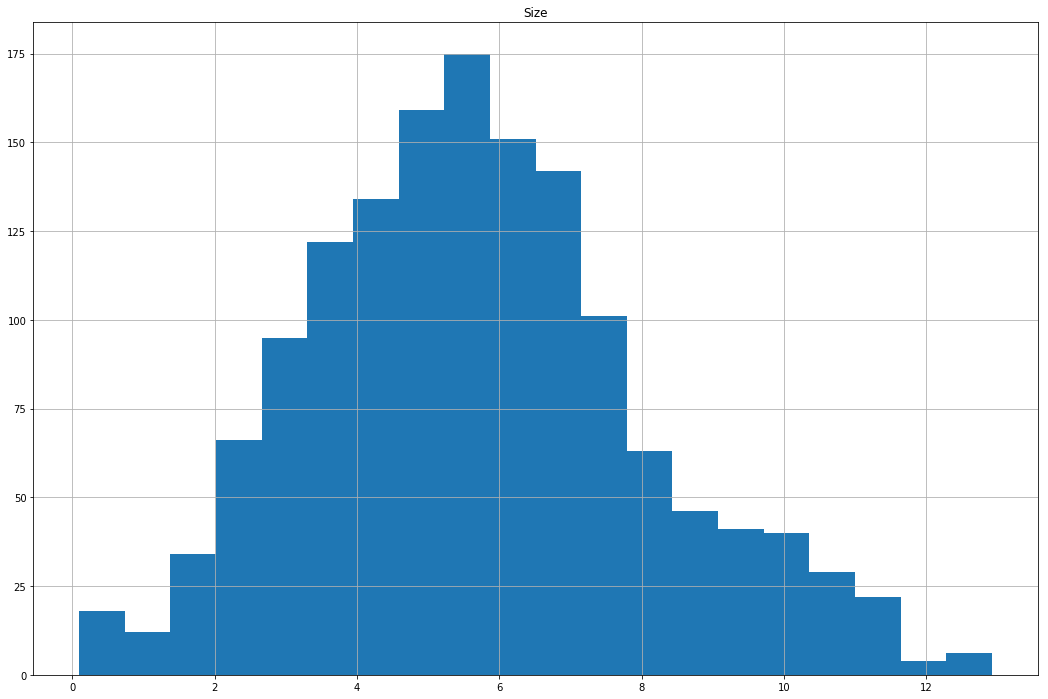

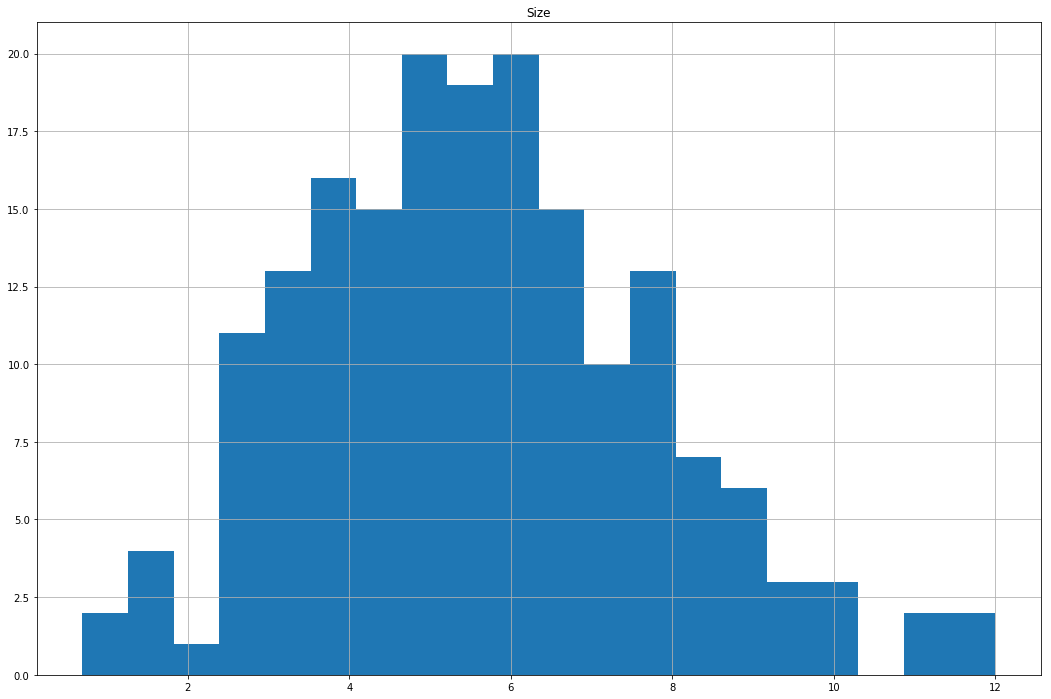

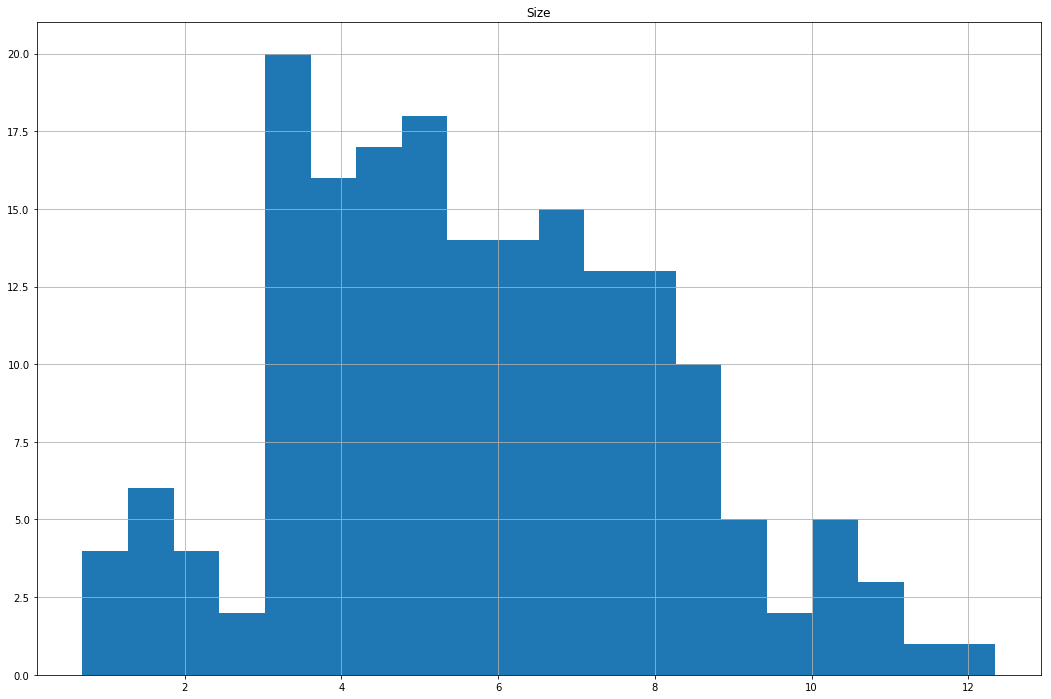

In [12]:

# construct training and validation examples
training_features,training_targets,validation_features,validation_targets,test_features,test_targets = preprocess_data(df)

training_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\training_features.csv')
training_targets.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\training_targets.csv')

validation_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\validation_features.csv')
validation_targets.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\validation_targets.csv')

test_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\test_features.csv')
test_targets.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\test_targets.csv')

_ = training_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
_ = validation_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)
_ = test_targets.hist(bins=20, figsize=(18, 12), xlabelsize=10)

# apply PCA

print(training_features)
print(training_targets)
print(validation_features)
print(validation_targets)
print(test_features)
print(test_targets)

# Double-check that we've done the right thing.
print("Training examples summary:")
display.display(training_features.describe())
print("Validation examples summary:")
display.display(validation_features.describe())
print("Test examples summary:")
display.display(test_features.describe())

print("Training targets summary:")
display.display(training_targets.describe())
print("Validation targets summary:")
display.display(validation_targets.describe())
print("Test targets summary:")
display.display(test_targets.describe())


In [13]:
# normalized_training_features = normalize(training_features)
# normalized_validation_features = normalize(validation_features)
# normalized_test_features = normalize(test_features)

# from sklearn.decomposition import KernelPCA
# from sklearn.datasets import make_circles

# # Create linearly inseperable data
# X, _ = make_circles(n_samples=1000, random_state=1, noise=0.1, factor=0.1)
# print(X)
# print(len(X))
# print(_)
# print(len(_))

# kpca = KernelPCA(kernel="rbf", gamma=15, n_components=1)
# X_kpca = kpca.fit_transform(X)
# # print(kpca)
# print(X_kpca)
# # PCA test
# from sklearn import datasets
# from sklearn.decomposition import PCA

# # load dataset
# # iris = datasets.load_iris()
# # df = pd.DataFrame(iris.data, columns=iris.feature_names)

# # print(df.head(3))

# # _ = df.hist(bins=20, figsize=(18, 12), xlabelsize=10)

# # normalize data
# # from sklearn import preprocessing

# # data_scaled = pd.DataFrame(preprocessing.scale(df), columns=df.columns)

# # _ = data_scaled.hist(bins=20, figsize=(18, 12), xlabelsize=10)

# print(normalized_training_features.shape)
# # print(len(data_scaled.index))
# # print(len(data_scaled.columns))
# print(normalized_training_features.head(3))

# # PCA
# # pca = PCA(n_components=2)

# pca = PCA(.95)

# # fitting PCA on training set
# pca.fit(normalized_training_df)
# pca_training_features = pca.fit_transform(normalized_training_features)
# pca_validation_features = 
# # apply the mapping (transform) to both training and test set
# # pca_training_features = pca.transform(data_scaled)
# # pca_validation_features = pca.transform(normalized_validation_features)
# # pca_test_features = pca.transform(normalized_test_features)


# # principalComponents = pca.fit_transform(data_scaled)

# # pca_training_features = pd.DataFrame(principalComponents)
# # pca_training_features = pd.DataFrame(pca_training_features)
# pca_contribution_matrix = pd.DataFrame(pca.components_,columns=data_scaled.columns)

# # pca_training_features = pd.DataFrame(pca.components_.T,
# #                                      index=normalized_training_features.columns)

# print(pca_training_features.head(3))
# print(pca_training_features.shape)
# # Dump components relations with features
# # , index=['PC-1', 'PC-2'])

# print(pca.components_)
# print(len(pca.components_))

# print(len(pca.components_[0]))
# # pca_training_features = pd.DataFrame(pca.components_, columns=data_scaled.columns)

# # print(pca_target_features)

# print(pca.explained_variance_ratio_)
# print(len(pca.explained_variance_ratio_))

# pca_training_features.to_csv('./data/pca_training_features.csv')


In [14]:
# normalize training and validation examples

normalized_training_features = normalize(training_features)
normalized_validation_features = normalize(validation_features)
normalized_test_features = normalize(test_features)

normalized_training_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\normalized_training_features.csv')


normalized_validation_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\normalized_validation_features.csv')


normalized_test_features.to_csv(r'C:\Users\Ricky\Documents\MATH 4025 Applied Math Capstone\predicting-wildfire-risk\data\normalized_test_features.csv')


# _ = normalized_training_features.hist(bins=20, figsize=(18, 12), xlabelsize=10)

In [15]:
# # gradient descent (less efficient)

# gd_dnn_regressor, gd_training_losses, gd_validation_losses = train_nn_regression_model(
#     my_optimizer=tf.train.GradientDescentOptimizer(learning_rate=0.001),
#     steps=5000,
#     periods=5,
#     batch_size=1,
#     hidden_units=[4],
#     training_examples=normalized_training_features,
#     training_targets=training_targets["Size"],
#     validation_examples=normalized_validation_features,
#     validation_targets=validation_targets["Size"])

In [16]:
# # adagrad optimizer
# adagrad_dnn_regressor, adagrad_training_losses, adagrad_validation_losses = train_nn_regression_model(
#     my_optimizer=tf.train.AdagradOptimizer(learning_rate=0.5),
#     steps=500,
#     periods=5,
#     batch_size=1,
#     hidden_units=[10, 10],
#     training_examples=normalized_training_features,
#     training_targets=training_targets,
#     validation_examples=normalized_validation_features,
#     validation_targets=validation_targets)

[87]
1
Training model...
RMSE (on training data):
  period 00 : 4.15
  period 01 : 10.07
  period 02 : 2.72
  period 03 : 2.44
  period 04 : 3.28
  period 05 : 3.36
  period 06 : 2.40
  period 07 : 2.37
  period 08 : 2.62
  period 09 : 3.45
Model training finished.
Final RMSE (on training data):   3.45
Final RMSE (on validation data): 3.96
total seconds elapsed:
178.34017872810364


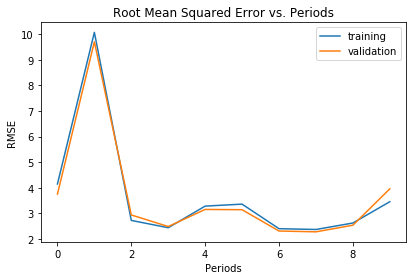

In [171]:
# adam optimizer
training_size = len(normalized_training_features.index)
batch_size = 1
steps = training_size / batch_size

hidden_units = []
hidden_layers = 1
for i in range(hidden_layers):
    # average of number of nodes in input and output layers
    # neurons = math.floor((len(normalized_training_features.columns)+1)/2)
    # number of nodes in input layer
    neurons = (len(normalized_training_features.columns))
    hidden_units.append(neurons)
print(hidden_units)
print(len(hidden_units))
start = time.time()
adam_dnn_regressor, adam_training_losses, adam_validation_losses = train_nn_regression_model(
    my_optimizer=tf.train.AdamOptimizer(learning_rate=0.001),
    steps=steps,
    periods=10,
    batch_size=batch_size,
    hidden_units=hidden_units,
    training_examples=normalized_training_features,
    training_targets=training_targets,
    validation_examples=normalized_validation_features,
    validation_targets=validation_targets,
    model_dir="models/config_1",
#     warm_start_from="models/config_1"
)
end = time.time()
print('total seconds elapsed:')
print(end - start)

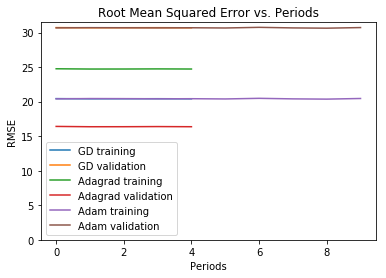

In [65]:
# plot of loss metrics for each optimizer
plt.ylabel("RMSE")
plt.xlabel("Periods")
plt.title("Root Mean Squared Error vs. Periods")
plt.plot(gd_training_losses, label='GD training')
plt.plot(gd_validation_losses, label='GD validation')
plt.plot(adagrad_training_losses, label='Adagrad training')
plt.plot(adagrad_validation_losses, label='Adagrad validation')
plt.plot(adam_training_losses, label='Adam training')
plt.plot(adam_validation_losses, label='Adam validation')
# plt.ylim(bottom=0)
_ = plt.legend()

In [172]:
adam_test_predictions = adam_dnn_regressor.predict(input_fn=predict_test_input_fn)
adam_test_predictions = np.array([item['predictions'][0] for item in adam_test_predictions])

adam_test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(test_targets, adam_test_predictions))

print("Adam Optimizer RMSE (on test data):")
print(adam_test_root_mean_squared_error)

adam_test_r2_score = metrics.r2_score(test_targets, adam_test_predictions)

print("Adam Optimizer R^2 (on test data):")
print(adam_test_r2_score)

Adam Optimizer RMSE (on test data):
4.491859340146081
Adam Optimizer R^2 (on test data):
-2.6661385647023637


In [97]:
n = 4

# predict test example
predict_features = normalized_test_features.copy().head(n)
print("predict_features:")
print(predict_features)

print("predict_targets:")
predict_targets = test_targets["Size"].head(n)
print(predict_targets)

predict_test_input_fn_2 = lambda: my_input_fn(predict_features, 
                                                    predict_targets, 
                                                    num_epochs=1, 
                                                    shuffle=False)

adam_test_predictions = adam_dnn_regressor.predict(input_fn=predict_test_input_fn_2)
adam_test_predictions = np.array([item['predictions'][0] for item in adam_test_predictions])
adam_test_errors = []

for i in range(len(adam_test_predictions)):
    adam_test_errors.append(np.array(predict_targets)[i] - adam_test_predictions[i])

print("predictions:")
print(adam_test_predictions)
print("errors:")
print(adam_test_errors)


adam_test_root_mean_squared_error = math.sqrt(
        metrics.mean_squared_error(predict_targets, adam_test_predictions))

print("Adam Optimizer RMSE (on test data):")
print(adam_test_root_mean_squared_error)

adam_test_r2_score = metrics.r2_score(predict_targets, adam_test_predictions)

print("Adam Optimizer R^2 (on test data):")
print(adam_test_r2_score)

predict_features:
      temperature_336  humidity_336  windSpeed_336  temperature_312  \
1081              0.1           0.4            0.2              0.2   
440              -0.8           1.0            0.6             -0.7   
1179              0.3          -0.6            0.5              0.3   
624              -0.3           0.6            0.0             -0.2   

      humidity_312  windSpeed_312  temperature_288  humidity_288  \
1081           0.3            0.5              0.2           0.3   
440            1.0            0.5             -0.8           0.2   
1179          -0.4            0.2              0.3          -0.4   
624            0.6            0.2             -0.1           0.6   

      windSpeed_288  temperature_264  ...  windSpeed264  temperature288  \
1081            0.3              0.2  ...           0.5            -0.2   
440             1.9             -0.6  ...           0.6            -0.3   
1179            0.3              0.2  ...           0.4     